# POSE_KEYPOINT_DETECTION_Detectron2_with_MaskR-CNN_on_COCO-Keypoint
1. Detects a entity(person in this case)
2. Creates a bounding box
3. Creates match-stick pattern keypoints

In [2]:
import sys, os, distutils.core

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
MODEL_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models'
INPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/input'
OUTPUT_DIR = '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output'

OUTPUT_KEYPOINT_DIR = "/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posekeypoint"


if not os.path.exists(OUTPUT_KEYPOINT_DIR):
    os.makedirs(OUTPUT_KEYPOINT_DIR)

# WARP_INPUTS = "/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/warp_input"

In [6]:
!git clone 'https://github.com/facebookresearch/detectron2.git' $MODEL_DIR/detectron2

fatal: destination path '/content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models/detectron2' already exists and is not an empty directory.


In [ ]:
# !cd $MODEL_DIR/detectron2

In [7]:
dist = distutils.core.run_setup(os.path.join(MODEL_DIR,"detectron2/setup.py"))
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath(os.path.join(MODEL_DIR,"detectron2")))




No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Ignoring dataclasses: markers 'python_version < "3.7"' don't match your environment
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.0 MB/s eta 0:00:00
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61396 sha256=9df25fbe0b4799260b3f60ecf1e65c23e7b619688abe09dd04a382ed51bf22a4
  Stored in directory: /root/.cache/pip/wheels/65/71/95/3b8fde5c65c6e4a806e0867c1651dcc71a1cb2f3430e8f355f
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-

In [8]:
!pip install -e $MODEL_DIR/detectron2

Obtaining file:///content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/models/detectron2
  Preparing metadata (setup.py) ... done
  Running setup.py develop for detectron2


In [9]:
import torch
import cv2
import numpy as np
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [11]:
# Load the model configuration
def load_pose_estimation_model():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
    predictor = DefaultPredictor(cfg)
    return predictor, cfg

In [15]:
# Perform pose estimation on an image and extract pose information
def detect_pose_and_extract_keypoints(image_path, predictor, cfg):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Run pose estimation
    outputs = predictor(image)

    # Extract keypoints
    keypoints = outputs["instances"].pred_keypoints.cpu().numpy()  # Get keypoints as NumPy array

    # Visualize the results (optional)
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pose_image = v.get_image()[:, :, ::-1]  # Convert back to BGR for OpenCV display

    # Save or display (optional)
    output_path = OUTPUT_KEYPOINT_DIR + "/clothing_keypoint.png"
    cv2.imwrite(output_path, pose_image)
    print(f"Pose estimation saved at: {output_path}")

    from google.colab.patches import cv2_imshow  # Import cv2_imshow
    cv2_imshow(pose_image) # Use cv2_imshow to display the image
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return keypoints  # Return the extracted keypoints

Pose estimation saved at: /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posekeypoint/clothing_keypoint.png


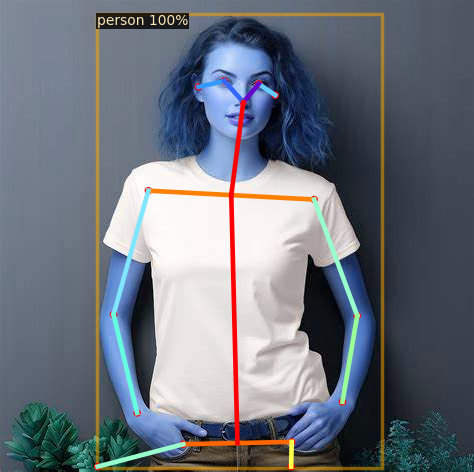

Keypoints saved to: /content/drive/MyDrive/498/WIPDocuments/Code/UseCase2/data/output/posekeypoint/person_keypoint.txt


In [16]:
# Run the pose estimation
# if __name__ == "__main__":
predictor, cfg = load_pose_estimation_model()
person_image = INPUT_DIR + "/person_image1.jpg"  # Replace with your image path
keypoints = detect_pose_and_extract_keypoints(person_image, predictor, cfg)

# Save keypoints to file
keypoints_file_path = OUTPUT_KEYPOINT_DIR + "/person_keypoint.txt"
np.savetxt(keypoints_file_path, keypoints.reshape(-1, keypoints.shape[-1]), delimiter=',')
print(f"Keypoints saved to: {keypoints_file_path}")
